In [84]:
import os
import numpy as np
import pandas as pd
import torch
import csv
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
from transformers import AutoModel, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('ai4bharat/indic-bert')
model = AutoModel.from_pretrained('ai4bharat/indic-bert')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 

The secret `HF_TOKEN` does not exist in your Colab secrets.

To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.

You will be able to reuse this secret in all of your notebooks.

Please note that authentication is recommended but still optional to access public models or datasets.

  warnings.warn(


config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
project_path = "/content/drive/MyDrive/Colab/SRL/"

In [5]:
!pip install conllu

In [6]:
sentences = []
srl_tags = []
csv_file = project_path + "output_dataset.csv"
with open(csv_file, 'r', encoding='utf-8') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)
    for row in csv_reader:
        sentence, srl = row
        words = sentence.split()
        srl_list = srl.split()
        sentences.append(words)
        srl_tags.append(srl_list)

In [7]:
dep_relations = []
csv_file2 = project_path + "output_drel_dataset.csv"
with open(csv_file2, 'r', encoding='utf-8') as file:
    csv_reader2 = csv.reader(file)
    next(csv_reader2)
    for row in csv_reader2:
        sentence, drel, srl = row
        drels = drel.split()
        dep_relations.append(drels)

In [8]:
print(dep_relations)

[['k7t', 'r6', 'k7', 'k1', 'root', 'rs', 'vmod', 'k7p', 'k1', 'k1s', 'ccof', 'ccof', 'r6', 'k7p', 'k1', 'k7', 'k1s', 'ccof'], ['k7t', 'k4', 'r6', 'k2', 'ccof', 'root', 'r6', 'k1', 'r6', 'k2', 'ccof'], ['nmod', 'k7p', 'r6', 'k1', 'root'], ['k1', 'k1u', 'jjmod', 'k1s', 'root'], ['k1', 'r6', 'k7p', 'k7p', 'ras-neg-k1', 'nmod', 'r6', 'root', 'k2', 'nmod__k1inv', 'r6', 'r6-k1', 'pof', 'root'], ['r6', 'k7', 'k7', 'k1u', 'r6', 'r6', 'k1', 'adv', 'ccof', 'root', 'rh', 'k1', 'ccof', 'rs', 'k7p', 'k1u', 'k1', 'pof', 'ccof'], ['root', 'nmod__k2inv', 'k1', 'k1u', 'root'], ['r6', 'jjmod', 'nmod', 'k7p', 'k1', 'root', 'k2', 'r6', 'k1', 'k1u', 'nmod', 'fragof', 'ccof', 'ccof', 'k1', 'r6', 'r6', 'k7', 'k1s', 'ccof'], ['root', 'k1', 'k7t', 'r6', 'root', 'k7p', 'root', 'nmod', 'k1u', 'ccof'], ['r6', 'k1', 'ccof', 'nmod', 'fragof', 'k1u', 'ccof', 'k1s', 'root'], ['root', 'k2', 'k1', 'k1s', 'ccof'], ['root', 'r6', 'r6', 'root', 'k2', 'vmod', 'pof', 'ccof', 'k2', 'k7p', 'r6', 'k1u', 'k1', 'k1s', 'ccof'], [

In [9]:
print(srl_tags)

[['ARGM-TMP', 'NO_SRL', 'ARG2-ATR', 'ARG1', 'NO_SRL', 'NO_SRL', 'ARGM-DIS', 'ARGM-LOC', 'ARG1', 'ARG2-ATR', 'NO_SRL', 'NO_SRL', 'NO_SRL', 'ARGM-LOC', 'ARG1', 'ARGM-MNR', 'ARG2-ATR', 'NO_SRL'], ['ARGM-TMP', 'ARG0', 'NO_SRL', 'ARG1', 'NO_SRL', 'NO_SRL', 'NO_SRL', 'ARG0', 'NO_SRL', 'ARG1', 'NO_SRL'], ['NO_SRL', 'ARGM-LOC', 'NO_SRL', 'ARG1', 'NO_SRL'], ['ARG1', 'ARGM-MNR', 'NO_SRL', 'ARG2-ATR', 'NO_SRL'], ['NO_SRL', 'NO_SRL', 'NO_SRL', 'NO_SRL', 'NO_SRL', 'NO_SRL', 'NO_SRL', 'NO_SRL', 'ARG1', 'NO_SRL', 'NO_SRL', 'ARG0', 'NO_SRL', 'NO_SRL'], ['NO_SRL', 'NO_SRL', 'ARGM-LOC', 'ARGM-MNR', 'NO_SRL', 'NO_SRL', 'ARG1', 'ARGM-TMP', 'NO_SRL', 'NO_SRL', 'ARGM-CAU', 'ARG1', 'NO_SRL', 'NO_SRL', 'NO_SRL', 'NO_SRL', 'NO_SRL', 'NO_SRL', 'NO_SRL'], ['NO_SRL', 'NO_SRL', 'ARG1', 'ARG2-ATR', 'NO_SRL'], ['NO_SRL', 'NO_SRL', 'NO_SRL', 'ARGM-LOC', 'ARG0', 'NO_SRL', 'ARG1', 'NO_SRL', 'ARG1', 'ARG2-ATR', 'NO_SRL', 'NO_SRL', 'NO_SRL', 'NO_SRL', 'ARG1', 'NO_SRL', 'NO_SRL', 'ARGM-LOC', 'ARG2-ATR', 'NO_SRL'], ['NO_SR

In [10]:
# labels = ["ARG0","ARG1","ARG2","ARG3","ARG2-ATR","ARG2-LOC","ARG2-GOL","ARG2-SOU","ARGM-PRX","ARGM-ADV",
#         "ARGM-DIR","ARGM-EXT","ARGM-MNR","ARGM-PRP","ARGM-DIS","ARGM-LOC","ARGM-MNS","ARGM-NEG","ARGM-TMP",
#           "ARGM-CAU", "NO_SRL"]
A = set()
for arr in srl_tags:
    for tag in arr:
        A.add(tag)
labels = list(A)
label_dict = {label: index for index, label in enumerate(labels)}

In [11]:
B = set()
for arr in dep_relations:
    for drel in arr:
        B.add(drel)
drs = list(B)
drel_dict = {dr: index for index, dr in enumerate(drs)}

In [12]:
drel_dict['NO_DR'] = 58
print(drel_dict)

{'k1g': 0, 'k2': 1, 'rd': 2, 'ccof': 3, 'adv': 4, 'k5prk': 5, 'k1': 6, 'ras-k1': 7, 'rsp': 8, 'ras-k7p': 9, 'rbmod': 10, 'enm': 11, 'k1s': 12, 'fragof': 13, 'k5': 14, 'k4a': 15, 'ras-r6': 16, 'nmod__k2inv': 17, 'vmod': 18, 'k2s': 19, 'jk1': 20, 'k4u': 21, 'k7ts': 22, 'ras': 23, 'ras-k7': 24, 'k1u': 25, 'mk1': 26, 'rs': 27, 'mod': 28, 'k7t': 29, 'nmod': 30, 'jjmod': 31, 'k7p': 32, 'k2p': 33, 'r6-k1': 34, 'ras-k2': 35, 'rbmod__relc': 36, 'ras-neg-k1': 37, 'r6-k2': 38, 'pof-idiom': 39, 'r6v': 40, 'vmod__adv': 41, 'k7pu': 42, 'k3': 43, 'pof': 44, 'rh': 45, 'k7': 46, 'pk1': 47, 'r6': 48, 'k2g': 49, 'rt': 50, 'nmod__k1inv': 51, 'sent-adv': 52, 'nmod__relc': 53, 'root': 54, 'nmod__pofinv': 55, 'k4': 56, 'k2u': 57, 'NO_DR': 58}


In [13]:
# tokenized_sentences = [tokenizer.encode(sentence, add_special_tokens=True) for sentence in sentences[:10]]
x_t = tokenizer.encode(sentences[0][2], add_special_tokens = False)
print(x_t)

[1520]


In [14]:
tokenized_output = tokenizer(sentences[1][5], padding=True, return_attention_mask=True)
attention_mask = tokenized_output["attention_mask"]
print("Attention Mask:", attention_mask)
print(tokenized_output)

Attention Mask: [1, 1, 1, 1]

{'input_ids': [2, 100705, 339, 3], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]}


In [15]:
print(srl_tags[0][2])
print(sentences[0][2])
print(label_dict['NO_SRL'])
print(label_dict)

ARG2-ATR

मन

9

{'ARGM-ADV': 0, 'ARG0': 1, 'ARG2-SOU': 2, 'ARG2-LOC': 3, 'ARGM-CAU': 4, 'ARGM-EXT': 5, 'ARGM-MOD': 6, 'ARGM-NEG': 7, 'ARG2': 8, 'NO_SRL': 9, 'ARG1': 10, 'ARGM-TMP': 11, 'ARGM-DIS': 12, 'ARG-UNDEF': 13, 'ARG2-ATR': 14, 'ARGM-LOC': 15, 'ARGM-PRX': 16, 'ARG3': 17, 'ARGM-MNR': 18, 'ARG2-GOL': 19, 'ARGM-MNS': 20, 'ARGM-DIR': 21, 'ARGM-PRP': 22}


In [16]:
sentence_indices = []
label_indices = []
dr_indices = []
max_enc = 0
for i, sent in enumerate(sentences):
    s_t = [2]
    srl = [label_dict['NO_SRL']]
    dr = [drel_dict['NO_DR']]
    for j, w in enumerate(sent):
        w_t = tokenizer.encode(w, add_special_tokens=False)
        max_enc = max(max_enc, len(w_t))
        s_t.extend(w_t)
        srl.extend([label_dict[srl_tags[i][j]]] * len(w_t))
        dr.extend([drel_dict[dep_relations[i][j]]] * len(w_t))
    label_indices.append(srl)
    sentence_indices.append(s_t)
    dr_indices.append(dr)

In [18]:
def pad(sentence_indices, label_indices, dr_indices):
    padded_sequences = []
    padded_labels = []
    padded_drels = []
    attention_masks = []  # Attention masks list of lists
    max_length = max(len(sent) for sent in sentence_indices)
    for sent, label, drel in zip(sentence_indices, label_indices, dr_indices):
        num_padding_tokens = max_length - len(sent)
        padded_sent = sent + [0] * num_padding_tokens
        padded_label = label + [label_dict['NO_SRL']] * num_padding_tokens
        padded_drel = drel + [drel_dict['NO_DR']] * num_padding_tokens
        attention_mask = [1] * len(sent) + [0] * num_padding_tokens
        padded_sequences.append(padded_sent)
        padded_labels.append(padded_label)
        padded_drels.append(padded_drel)
        attention_masks.append(attention_mask)
    return padded_sequences, padded_labels, padded_drels, attention_masks

In [19]:
pad_sentence_indices, pad_label_indices, padded_drel_indices, masks = pad(sentence_indices, label_indices, dr_indices)

In [20]:
Xtrain = pad_sentence_indices[:-300]
train_masks = masks[:-300]
train_drel_indices = padded_drel_indices[:-300]
Ytrain = pad_label_indices[:-300]

Xtest = pad_sentence_indices[-300:]
test_masks = masks[-300:]
test_drel_indices = padded_drel_indices[-300:]
Ytest = pad_label_indices[-300:]

---
---

<br>


In [22]:
def getEmbedding(sentence, mask):
    attention_mask = torch.tensor([mask])
    input_tensor = torch.tensor([sentence])
    with torch.no_grad():
        outputs = model(input_tensor, attention_mask = attention_mask)
    lhs = outputs.last_hidden_state
    embeddings = lhs[0]
    return embeddings

---
---

<br>

In [24]:
def saveModel(model, path):
    torch.save(model.state_dict(), path)

def loadModel(model, path):
    if device == 'cuda':
        model.load_state_dict(torch.load(path))
    else:
        model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

In [25]:
criterion = nn.CrossEntropyLoss()

In [26]:
class SRLClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SRLClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim // 2, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out.contiguous().view(-1, self.hidden_dim))
        return out

In [27]:
class SRLClassifierWithDR(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SRLClassifierWithDR, self).__init__()
        relation_embedding_dim = 768
        num_relations = len(drel_dict)
        self.hidden_dim = hidden_dim
        self.relation_embedding_layer = nn.Embedding(num_relations, relation_embedding_dim)
        self.lstm = nn.LSTM(input_dim + relation_embedding_dim, hidden_dim // 2, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, relation_indices):
        relation_embeddings = self.relation_embedding_layer(relation_indices)
        concatenated_embeddings = torch.cat((x, relation_embeddings), dim=2)
        lstm_out, _ = self.lstm(concatenated_embeddings)
        out = self.fc(lstm_out.contiguous().view(-1, self.hidden_dim))
        return out

In [28]:
def defineModel(input_dim, hidden_dim, output_dim):
    srl_classifier1 = SRLClassifier(input_dim, hidden_dim, output_dim).to(device)
    optimizer1 = optim.Adam(srl_classifier1.parameters(), lr = 0.001)
    srl_classifier2 = SRLClassifierWithDR(input_dim, hidden_dim, output_dim).to(device)
    optimizer2 = optim.Adam(srl_classifier2.parameters(), lr = 0.001)
    return srl_classifier1, optimizer1, srl_classifier2, optimizer2

In [76]:
classifier1, optimizer1, classifier2, optimizer2 = defineModel(input_dim=768, hidden_dim=32, output_dim=len(label_dict))

In [64]:
sent_embeddings = []
for sent, mask in zip(Xtrain, train_masks):
    encoded_sent = getEmbedding(sent, mask = mask)
    sent_embeddings.append(encoded_sent)

In [65]:
def train3(classifier, Xtrain, train_drel_indices, Ytrain, n_epochs, optimizer):
    losses = []
    for epoch in range(n_epochs):
        classifier.train()
        running_loss = 0.0
        with tqdm(total=len(Xtrain), desc=f"Epoch {epoch+1}/{n_epochs}") as pbar:
            i = 0
            for sent, rel_tags, labels in zip(Xtrain, train_drel_indices, Ytrain):
                optimizer.zero_grad()
                encoded_sent = sent_embeddings[i]
                X = encoded_sent.reshape(1, encoded_sent.size(0), encoded_sent.size(1))
                inputs = X.to(device)
                features = torch.tensor(rel_tags).to(device)
                features = features.reshape(1, features.size(0))
                targets = torch.tensor(labels).to(device)
                targets = targets.reshape(1, targets.size(0))
                outputs = classifier(inputs, features).to(device)
                reshaped_outputs = outputs.view(-1, outputs.size(-1))
                reshaped_targets = targets.view(-1)
                loss = criterion(reshaped_outputs, reshaped_targets)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                pbar.update(1)
                i += 1
        epoch_loss = running_loss / len(Xtrain)
        losses.append(epoch_loss)
        print(f"Epoch {epoch+1}, Loss: {epoch_loss}\n")
    return losses

In [77]:
L3 = train3(classifier2, Xtrain, train_drel_indices, Ytrain, 10, optimizer2)

Epoch 1/10: 100%|██████████| 1007/1007 [00:10<00:00, 93.17it/s]


Epoch 1, Loss: 0.33858618138925856




Epoch 2/10: 100%|██████████| 1007/1007 [00:09<00:00, 101.06it/s]


Epoch 2, Loss: 0.19741124808399863




Epoch 3/10: 100%|██████████| 1007/1007 [00:11<00:00, 89.20it/s] 


Epoch 3, Loss: 0.18290860836635517




Epoch 4/10: 100%|██████████| 1007/1007 [00:11<00:00, 87.96it/s]


Epoch 4, Loss: 0.17538666600119157




Epoch 5/10: 100%|██████████| 1007/1007 [00:10<00:00, 95.51it/s]


Epoch 5, Loss: 0.1684868029617476




Epoch 6/10: 100%|██████████| 1007/1007 [00:10<00:00, 97.60it/s] 


Epoch 6, Loss: 0.16495417600891588




Epoch 7/10: 100%|██████████| 1007/1007 [00:12<00:00, 78.29it/s] 


Epoch 7, Loss: 0.16087513237399934




Epoch 8/10: 100%|██████████| 1007/1007 [00:11<00:00, 88.44it/s] 


Epoch 8, Loss: 0.15682010981971037




Epoch 9/10: 100%|██████████| 1007/1007 [00:10<00:00, 99.60it/s]


Epoch 9, Loss: 0.15279244269866796




Epoch 10/10: 100%|██████████| 1007/1007 [00:10<00:00, 99.38it/s]

Epoch 10, Loss: 0.15104318498943625




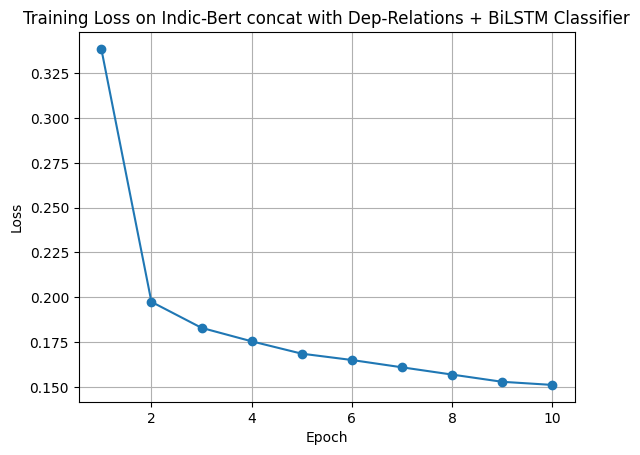

In [86]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(L3) + 1), L3, marker='o', linestyle='-')
plt.title('Training Loss on Indic-Bert concat with Dep-Relations + BiLSTM Classifier')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [67]:
test_embeddings = []
for sent, mask in zip(Xtest, test_masks):
    encoded_sent = getEmbedding(sent, mask = mask)
    test_embeddings.append(encoded_sent)

In [81]:
def evaluate(classifier, Xtest, Ytest):
    classifier.eval()
    total_samples = 0
    correct_samples = 0
    predicted_labels_all = []
    true_labels_all = []

    with torch.no_grad():
        for i, (labels, relations) in enumerate(zip(Ytest, test_drel_indices)):
            encoded_sent = test_embeddings[i]
            inputs = encoded_sent.unsqueeze(0).to(device)
            features = torch.tensor(relations).to(device)
            features = features.reshape(1, features.size(0))
            targets = torch.tensor(labels).to(device)
            outputs = classifier(inputs, features).to(device)
            predicted_labels = outputs.max(dim=1)[1].view(-1)
            total_samples += len(labels)
            correct_samples += (predicted_labels == targets).sum().item()
            predicted_labels_all.extend(predicted_labels.cpu().numpy())
            true_labels_all.extend(targets.cpu().numpy())
    accuracy = accuracy_score(true_labels_all, predicted_labels_all)
    precision = precision_score(true_labels_all, predicted_labels_all, average='weighted')
    recall = recall_score(true_labels_all, predicted_labels_all, average='weighted')
    f1 = f1_score(true_labels_all, predicted_labels_all, average='weighted')
    return accuracy, precision, recall, f1

In [82]:
a, p, r, f1 = evaluate(classifier2, Xtest, Ytest)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))


In [83]:
print(a)
print(p)
print(r)
print(f1)

0.953421052631579

0.9510013128407974

0.953421052631579

0.9515507384326396
